### Importing libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


### Loading data and EDA

In [2]:
# Load dataset
df = pd.read_csv('input/cosmetics.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   Brand        1472 non-null   object 
 2   Name         1472 non-null   object 
 3   Price        1472 non-null   int64  
 4   Rank         1472 non-null   float64
 5   Ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


In [4]:
df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


In [5]:
print(df.shape)

(1472, 11)


In [6]:
print(df.describe())

             Price         Rank  Combination          Dry       Normal  \
count  1472.000000  1472.000000   1472.00000  1472.000000  1472.000000   
mean     55.584239     4.153261      0.65625     0.614130     0.652174   
std      45.014429     0.633918      0.47512     0.486965     0.476442   
min       3.000000     0.000000      0.00000     0.000000     0.000000   
25%      30.000000     4.000000      0.00000     0.000000     0.000000   
50%      42.500000     4.300000      1.00000     1.000000     1.000000   
75%      68.000000     4.500000      1.00000     1.000000     1.000000   
max     370.000000     5.000000      1.00000     1.000000     1.000000   

              Oily    Sensitive  
count  1472.000000  1472.000000  
mean      0.607337     0.513587  
std       0.488509     0.499985  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       1.000000     1.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000  


In [7]:
print(df.isnull().sum())

Label          0
Brand          0
Name           0
Price          0
Rank           0
Ingredients    0
Combination    0
Dry            0
Normal         0
Oily           0
Sensitive      0
dtype: int64


In [8]:
data = df.drop_duplicates()  # Remove duplicate rows

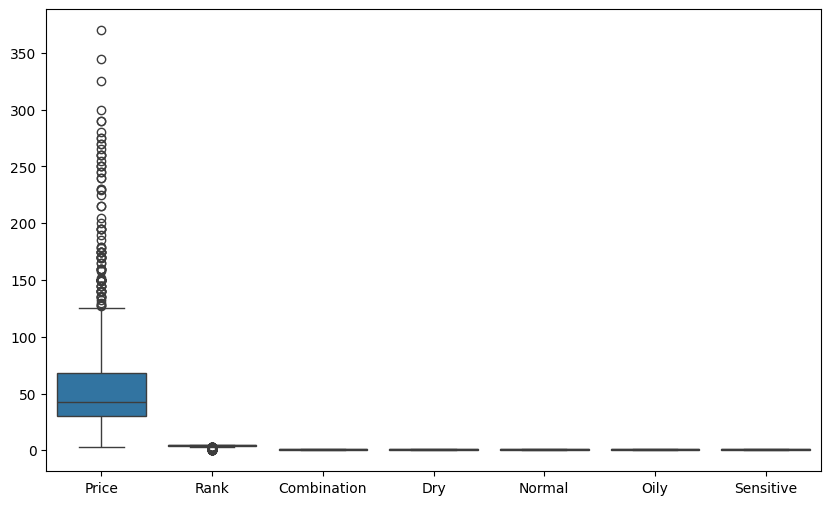

In [9]:
numerical_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,6))
sns.boxplot(data=data[numerical_cols])
plt.show()

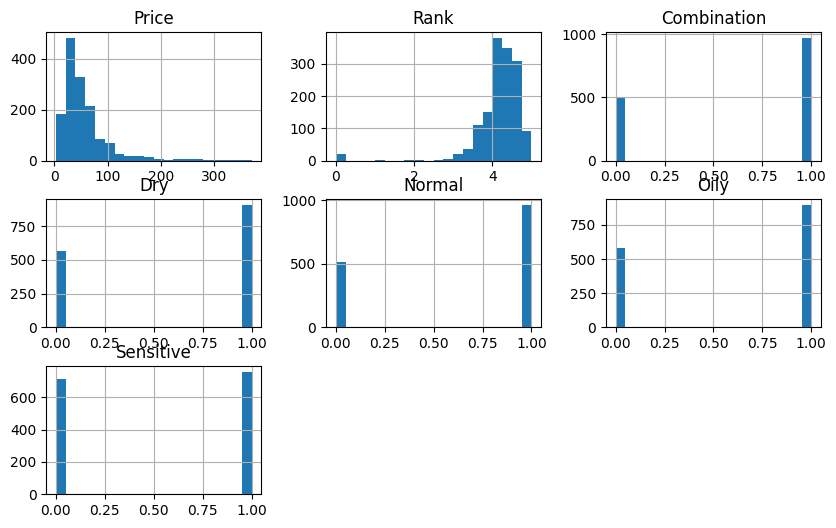

In [10]:
data[numerical_cols].hist(bins=20, figsize=(10, 6))
plt.show()

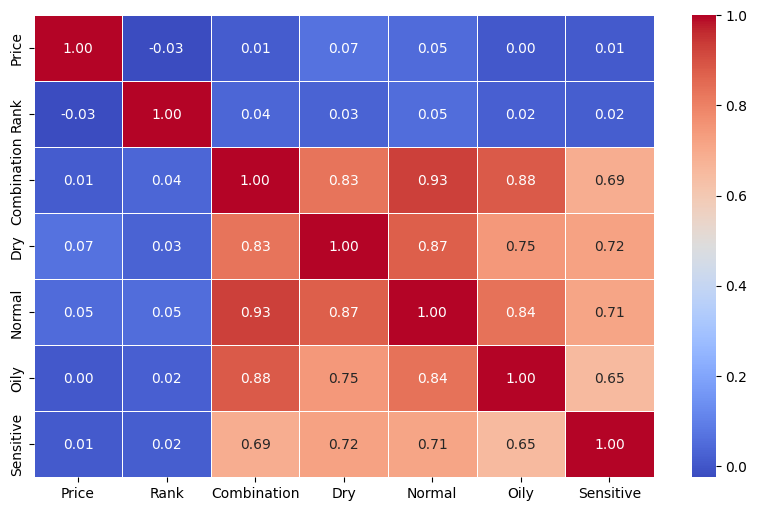

In [11]:
corr = data[numerical_cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

### Data Preprocessing

In [12]:
df['features'] = df['Ingredients']

### Feature Extraction 

In [70]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['features'])

In [71]:
# Compute cosine similarity between all products based on their TF-IDF features
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [72]:
# Create an Index Map
indices = pd.Series(df.index, index=df['Name']).drop_duplicates()

In [73]:
# Model Training and Evaluation (SVM, KNN, Random Forest)
X = tfidf_matrix  # Use the TF-IDF matrix as the feature set
y = df['Label']  # Target variable: Product label

In [74]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
# Models
svm_model = SVC(kernel='linear', probability=True)
knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [76]:
# Train models
svm_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [77]:
# Evaluate models
svm_accuracy = accuracy_score(y_test, svm_model.predict(X_test))
knn_accuracy = accuracy_score(y_test, knn_model.predict(X_test))
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

In [78]:
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")
print(f"KNN Accuracy: {knn_accuracy * 100:.2f}%")
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

SVM Accuracy: 49.49%
KNN Accuracy: 31.19%
Random Forest Accuracy: 50.17%


In [81]:
def recommend_cosmetics(skin_type, label_filter, rank_filter, brand_filter, price_range, ingredient_input=None, num_recommendations=10, model='SVM'):
    recommended_products = df[df[skin_type] == 1]
    
    if label_filter != 'All':
        recommended_products = recommended_products[recommended_products['Label'] == label_filter]
    
    recommended_products = recommended_products[
        (recommended_products['Rank'] >= rank_filter[0]) & 
        (recommended_products['Rank'] <= rank_filter[1])
    ]
    
    if brand_filter != 'All':
        recommended_products = recommended_products[recommended_products['Brand'] == brand_filter]
    
    recommended_products = recommended_products[
        (recommended_products['Price'] >= price_range[0]) & 
        (recommended_products['Price'] <= price_range[1])
    ]

    if ingredient_input:
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(df['Ingredients'])
        input_vec = vectorizer.transform([ingredient_input])
        cosine_similarities = cosine_similarity(input_vec, tfidf_matrix).flatten()
        recommended_indices = cosine_similarities.argsort()[-num_recommendations:][::-1]
        ingredient_recommendations = df.iloc[recommended_indices]
        recommended_products = recommended_products[recommended_products.index.isin(ingredient_recommendations.index)]
    
    # Get the indices of recommended products
    recommended_indices = recommended_products.index.tolist()

    # Extract the corresponding rows from the sparse matrix
    recommended_tfidf_matrix = tfidf_matrix[recommended_indices]

    # Add classification-based filtering (predicting label using the selected model)
    if model == 'SVM':
        predicted_labels = svm_model.predict(recommended_tfidf_matrix)
    elif model == 'KNN':
        predicted_labels = knn_model.predict(recommended_tfidf_matrix)
    else:
        predicted_labels = rf_model.predict(recommended_tfidf_matrix)
    
    recommended_products['Predicted_Label'] = predicted_labels
    
    # Prioritize products with the predicted label (increase diversity)
    recommended_products = recommended_products.sort_values(by=['Predicted_Label', 'Rank'])
    
    return recommended_products.head(num_recommendations)


In [83]:
# 8. Sample Input and Recommendation for All Models
sample_skin_type = 'Oily'
sample_label_filter = 'All'
sample_rank_filter = (1, 5)  # Rank between 1 and 5
sample_brand_filter = 'All'
sample_price_range = (10.0, 100.0)  # Price range between 10 and 100
sample_ingredient_input = 'Aloe Vera, Glycerin'

# Get top recommended products for each model (SVM, KNN, Random Forest)
for model_option in ['SVM', 'KNN', 'Random Forest']:
    print(f"\nTop Recommended Products using {model_option}:")
    top_recommended_products = recommend_cosmetics(
        sample_skin_type, sample_label_filter, sample_rank_filter, sample_brand_filter, 
        sample_price_range, sample_ingredient_input, model=model_option
    )
    print(top_recommended_products[['Label', 'Brand', 'Name', 'Ingredients', 'Rank']].T)


Top Recommended Products using SVM:
                                                          540   \
Label                                                 Cleanser   
Brand                                                    GO-TO   
Name                                       Exfoliating Swipeys   
Ingredients  Water, Lactic Acid, Aloe Vera, Ethanol, Propan...   
Rank                                                       4.9   

                                                          106   \
Label                                              Moisturizer   
Brand                                              JOSIE MARAN   
Name                             Whipped Argan Oil Face Butter   
Ingredients  Water**, Aloe Barbadensis (Aloe Vera) Leaf Jui...   
Rank                                                       4.1   

                                                          1434  \
Label                                              Sun protect   
Brand                                